# English Wikipedia page views 2007-2018
## Francisco Javier Salido Magos
Human Centered Data Science, DATA 512, Fall 2018.
M.S. Data Science,
University of Washington.

Homework A1, version 1.0

This code is made available for re-use under a MIT license. (https://opensource.org/licenses/MIT)

In [15]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Data Acquisition
## Preparing the environment to extract Wikipedia public data using the REST API
We first declare the endpoints for the API. Two endpoints, one for legacy data and one for current standard data. These are the actual "locations" in Wikimedia to which the extraction requests will be sent, via API calls.

In [16]:
# Endpoints for API to download data. 
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

Below we set the parameters for data extraction through the API calls. We have 5 sets of parameters, 2 sets for API calls that will download legacy data, and 3 for API calls that will download current standard data. 
Legacy data calls using these parameters will each download a data set, one for desktop page counts and another for mobile page counts. For current standard data parameters correspond to an API call that will download a desktop pageview set, and parameters for API calls that will download two mobile pageview sets, one for website views and one for on-app views.

In [17]:
# Parameters for getting aggregated legacy view data 
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
params_legacy_desk = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2018100100"
                    }

params_legacy_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2018100100"
                    }

# Parameters for getting aggregated current standard pageview data
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
params_pageviews_desk = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2018111000'
                        }

params_pageviews_mobileweb = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2018111000'
                        }

params_pageviews_mobileapp = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2018111000'
                        }

# Headers with personal data that will be relayed with the API calls, for reference purposes.
headers = {
    'User-Agent': 'https://github.com/PrivacyEngineer',
    'From': 'javiers@uw.edu'
}

## Issuing calls to download data
First, a function is declared that will make all API calls, using the appropriate set of parameters, defined above, for each specific data set.

In [18]:
# This function calls the API with provided parameters to get the data.
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

Below are the 5 calls to the API, one for each dataset:
    - Legacy desktop
    - Legacy mobile
    - Current standard desktop
    - Current standard mobile website
    - Current standard mobile app

In [19]:
# These are the actual calls to the API to download legacy data.
monthly_legacy_desk = api_call(endpoint_legacy, params_legacy_desk)
monthly_legacy_mobile = api_call(endpoint_legacy, params_legacy_mobile)

# These are the actual calls to the API to download current standard pageview data.
monthly_pageviews_desk = api_call(endpoint_pageviews, params_pageviews_desk)
monthly_pageviews_mobileweb = api_call(endpoint_pageviews, params_pageviews_mobileweb)
monthly_pageviews_mobileapp = api_call(endpoint_pageviews, params_pageviews_mobileapp)

## Saving a copy of the original raw data
The block of code below stores the raw data sets that were downloaded in response to the API calls, in JSON format, to disk. We have one JSON file for each of the 5 datasets, with named files following the convention specified by the homework instructions.

In [20]:
# Writing raw legacy data downloaded using REST API on 10/16/2018 to disk, to two JSON files, one for desktop views and one for mobile device views.
with open('c:/Users/Castor18/OneDrive/MSDS_UW/Data512_Aut18/Session 3/Hmwk_A1/raw_data/pagecounts_desktop-site_200712-201608.json','w') as outfile:
    json.dump(monthly_legacy_desk,outfile)
with open('c:/Users/Castor18/OneDrive/MSDS_UW/Data512_Aut18/Session 3/Hmwk_A1/raw_data/pagecounts_mobile-site_201410-201608.json','w') as outfile:
    json.dump(monthly_legacy_mobile,outfile)
    
# Writing raw, current standard pageview data downloaded using REST API on 10/16/2018 to disk, to three JSON files.
# One for desktop views, one for mobile device views through the website, and one for mobile device views through the app.
with open('c:/Users/Castor18/OneDrive/MSDS_UW/Data512_Aut18/Session 3/Hmwk_A1/raw_data/pageviews_desktop_201507-201809.json','w') as outfile:
    json.dump(monthly_pageviews_desk,outfile)
with open('c:/Users/Castor18/OneDrive/MSDS_UW/Data512_Aut18/Session 3/Hmwk_A1/raw_data/pageviews_mobile-web_201507-201809.json','w') as outfile:
    json.dump(monthly_pageviews_mobileweb,outfile)
with open('c:/Users/Castor18/OneDrive/MSDS_UW/Data512_Aut18/Session 3/Hmwk_A1/raw_data/pageviews_mobile-app_201507-201809.json','w') as outfile:
    json.dump(monthly_pageviews_mobileapp,outfile)

# Step 2: Data Processing
## Combine monthly values for mobile-app and mobile-web
Next we transform the two mobile current standard pageview datasets, website and app, and transform them from the JSON format they are in, into a PANDAS data frame (actually a table format), where each item type from the JSON file becomes a column in the frame. We concatenate the resulting two data frames and, for each unique timestamp in the new dataset, aggregate the two quantities, mobile website and mobile app pageviews. Finally, since the sum() operation on the data frame strips off columns, we add the relevant missing data back and re-index the dataframe. 

In [21]:
# JSON formatted raw current standard pageview data for the mobile website and the mobile app, two files, are first transformed 
# into Data Frames where each data type/attribute is assigned a column in the data frame. The two data frames are then concatenated.
pageviews_mobile = pd.concat([pd.DataFrame(monthly_pageviews_mobileweb['items']),pd.DataFrame(monthly_pageviews_mobileapp['items'])])
# Add mobile web site and mobile app pageviews for each month into a single total named "mobile"
pageviews_mobile = pageviews_mobile.groupby(['timestamp']).sum()

# Drop attributes we will not be using in our processing, rename the attributes to match other data frames and re-index the frame.
pageviews_mobile['access'] = 'mobile-web'
pageviews_mobile['timestamp'] = pageviews_mobile.index
pageviews_mobile = pageviews_mobile[['access','timestamp','views']]
pageviews_mobile.reset_index(drop = True, inplace = True)

## Putting all five data sets together into a single data structure
The previous section of code took care of preparing two of the original five sets of raw data. The block of code below reformats the other three JSON data sets, tranforming them into PANDAS data frames and formatting them so that all three data frames, and the data frame from the previous block of code, can be concatenated into a single frame containing all data sets.

In [22]:
# JSON formatted raw legacy data for both desktop and mobile, as well as raw current standard pageview data for desktop are
# transformed into data frames where each data type/attribute is assigned a column in the data frame. Drop attributes we will
# not be using and rename columns.
legacy_desk = pd.DataFrame(monthly_legacy_desk['items'])
legacy_desk = legacy_desk[['access-site','timestamp','count']]
legacy_desk.rename(columns = {'access-site':'access','count':'views'},inplace=True)

legacy_mobile = pd.DataFrame(monthly_legacy_mobile['items'])
legacy_mobile = legacy_mobile[['access-site','timestamp','count']]
legacy_mobile.rename(columns = {'access-site':'access','count':'views'},inplace=True)

pageviews_desk = pd.DataFrame(monthly_pageviews_desk['items'])
pageviews_desk = pageviews_desk[['access','timestamp','views']]

# Concatenate all four data frames, legacy and current standard pageviews for both desktop and mobile, into a single data frame.
# Re-index the new data frame.
allup_raw = pd.concat([pageviews_mobile,pageviews_desk,legacy_mobile,legacy_desk])
allup_raw.reset_index(drop = True, inplace = True)

## Combining data into a single .csv file and storing it
We generate a list of unique timestaps and use it to identify those data points that correspond all to the same mont/year. We then create a NUMPY matrix with the same attributes as the desired .csv file and process the data into this format. Finally, we transform the matrix to a data frame and store the .csv file under the specified name.

In [23]:
# Take the concatenated data frames and build a matrix with the structure that will be required
# for our the final .csv file, as per stipulated requirements. Once matrix is built, it is transformed into a data frame,
# reindexed and stored to disk with the required name.

# Create matrix, populate it with zeroes and build a list of all unique values for the timestamp.
count = 0
unique_timestamps = allup_raw.timestamp.unique()
values = np.zeros((unique_timestamps.size,8), dtype = 'int64')

# Take values from the concatenated data frame and populate the matrix cells with the appropriate values
for time in unique_timestamps:
    current_stamp = allup_raw.loc[allup_raw['timestamp'] == time]
    current_stamp.reset_index(drop = True, inplace = True)
    nrows = current_stamp.shape[0]
    values[count,0] = current_stamp.iloc[0,1][:4]
    values[count,1] = current_stamp.iloc[0,1][4:6]
    count2 = 0
    for j in range(nrows):
        if current_stamp.access[j] == 'desktop-site':
            values[count][3] = int(current_stamp.iloc[j]['views'])
            count2 += 1
        elif current_stamp.access[j] == 'mobile-site':
            values[count][4] = int(current_stamp.iloc[j]['views'])
            count2 +=1
        elif current_stamp.access[j] == 'desktop':
            values[count][6] = int(current_stamp.iloc[j]['views'])
            count2 += 1
        elif current_stamp.access[j] == 'mobile-web':
            values[count][7] = int(current_stamp.iloc[j]['views'])
            count2 +=1
    values[count][2] = values[count][3] + values[count][4]
    values[count][5] = values[count][6] + values[count][7]
    count += 1

# Transform matrix into a data frame, reindex and store on disk.
columns = ['year','month','pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']
output = pd.DataFrame(values,columns=columns)
output = output.sort_values(['year','month'],ascending=True)
output.reset_index(drop = True, inplace = True)
output.to_csv('c:/Users/Castor18/OneDrive/MSDS_UW/Data512_Aut18/Session 3/Hmwk_A1/data_clean/en-wikipedia_traffic_200701-201809.csv')

# Step 3: Analysis
## Removing outliers
In this step we fist discard the data point for December 2007 (which seems to be a partial count) as well as all data points with values below the threshold specified by the variable "lbound". This is done in part so that the final graph is not as cluttered by a large number of data points with value zero, and also to eliminate some outliers with very low values which we deemed inaccurate given that they were collected as collection under the legacy model ended, or as collection under the current standard of pageview collections started.

## Building the graph
After this, we define the figure space, plot a graph for each of our four datasets, plus an additional two graphs with the total sum for legacy and for current standard pageviews, and then format the graph.

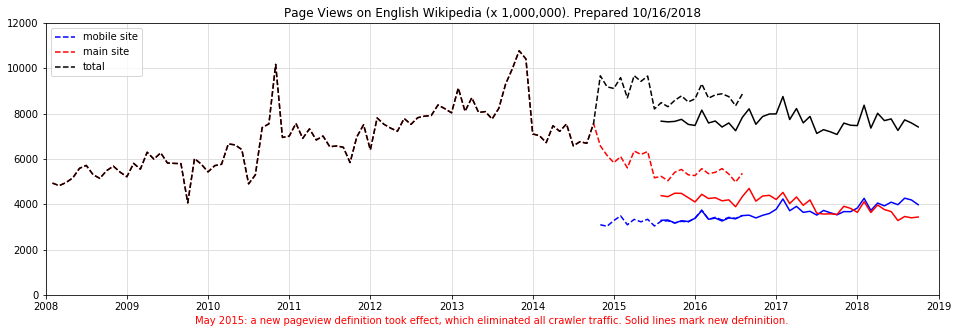

In [24]:
# Line below drops the data point for December 2007.
output = output.drop(output.index[0])
# We use the variable lbound to define a threshold for outliers. With this we seek to filter out all instances in which
# one of the plots has a value of zero (no data for that month), as well as instances in which the measurements showed
# very low values, pressumably because legacy counts stopped or current standard counts were just getting started.
lbound = 2000000000

# This portion of the code creates a figure/canvas to plot the data, formats it according to specifications and plots the
# six time series: desktop, mobile and total for both legacy and current standard pageviews.
plt.rcParams['figure.figsize'] = [16.0, 5.0]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Actual plotting of the data.
plt.plot(output['pageview_mobile_views'].loc[output['pageview_mobile_views'] > lbound], color = 'b',label='')
plt.plot(output['pageview_desktop_views'].loc[output['pageview_desktop_views'] > lbound], color = 'r',label='')
plt.plot(output['pageview_all_views'].loc[output['pageview_all_views'] > lbound], color = 'k',label='')
plt.plot(output['pagecount_mobile_views'].loc[output['pagecount_mobile_views'] > lbound], 'k--', color = 'b', label='mobile site')
plt.plot(output['pagecount_desktop_views'].loc[output['pagecount_desktop_views'] > lbound], 'k--', color = 'r', label='main site')
plt.plot(output['pagecount_all_views'].loc[output['pagecount_all_views'] > lbound], 'k--', color = 'k', label='total')

# Formatting the graph space and adding title, legends and label.
ticksx = ax.set_xticks([0,12,24,36,48,60,72,84,96,108,120,132])
ticksy = ax.set_yticks([0,2000000000,4000000000,6000000000,8000000000,10000000000,12000000000])
labelsx = ax.set_xticklabels(['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019'])
labelsy = ax.set_yticklabels(['0','2000','4000','6000','8000','10000','12000'])
plt.grid(b=True, which='both', color='0.85', linestyle='-')
ax.set_xlim([0,132])
ax.set_title('Page Views on English Wikipedia (x 1,000,000). Prepared 10/16/2018')
ax.set_xlabel('May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new defninition.',color='r')
plt.legend(loc='upper left')